## Unsupervised Learning
## Project: Creating Customer Segments

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [61, 244, 315]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,35942,38369,59598,3254,26701,2017
1,6202,7775,10817,1183,3143,1970
2,1479,14982,11924,662,3891,3508


Here we can see a heatmap showing the percentile for the samples:

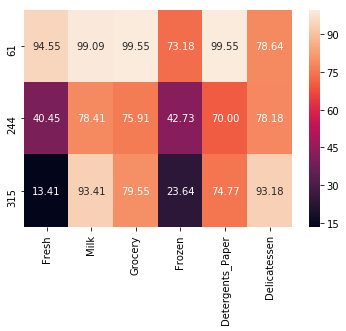

In [4]:
percentiles_data = 100*data.rank(pct=True)
percentiles_samples = percentiles_data.iloc[indices]
sns.heatmap(percentiles_samples, annot=True, fmt='.2f')

### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  

* What kind of establishment (customer) could each of the three samples you've chosen represent?

**Hint:** Examples of establishments include places like markets, cafes, delis, wholesale retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant. You can use the mean values for reference to compare your samples with. The mean values are as follows:

* Fresh: 12000.2977
* Milk: 5796.2
* Grocery: 7951.3
* Frozen: 3071.9
* Detergents_paper: 2881.4
* Delicatessen: 1524.8

Knowing this, how do your samples compare? Does that help in driving your insight into what kind of establishments they might be? 


**Answer:**

We can use the mean values given above and the percentiles heatmap to have an insight of the kind of establishments each sample might be.

**First example**: the costs are very high for every feature, this could indicate a wholesale store.

**Second example**: we can see that the purchase cost for Milk, Grocery and Delicatessen products are hi
gh, above the mean values. One might say that it is a cafe.

**Last example**: the Milk, Grocery and Delicatessen values are very high, even more than the second example. This could indicate a bakery.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Milk', axis=1)

# TODO: Split the data into training and testing sets(0.25) using the given feature as the target
# Set a random state.

X_train, X_test, y_train, y_test = train_test_split(new_data, data['Milk'], test_size=0.25, random_state=42)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print(score)

0.15627539501732116


### Question 2

* Which feature did you attempt to predict? 
* What was the reported prediction score? 
* Is this feature necessary for identifying customers' spending habits?

**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that that feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

**Answer:**

* Which feature did you attempt to predict?
> I attempted to predict the 'Milk' feature
* What was the reported prediction score? 
> 0.1563
* Is this feature necessary for identifying customers' spending habits?
> Yes, it is necessary because the score is low.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

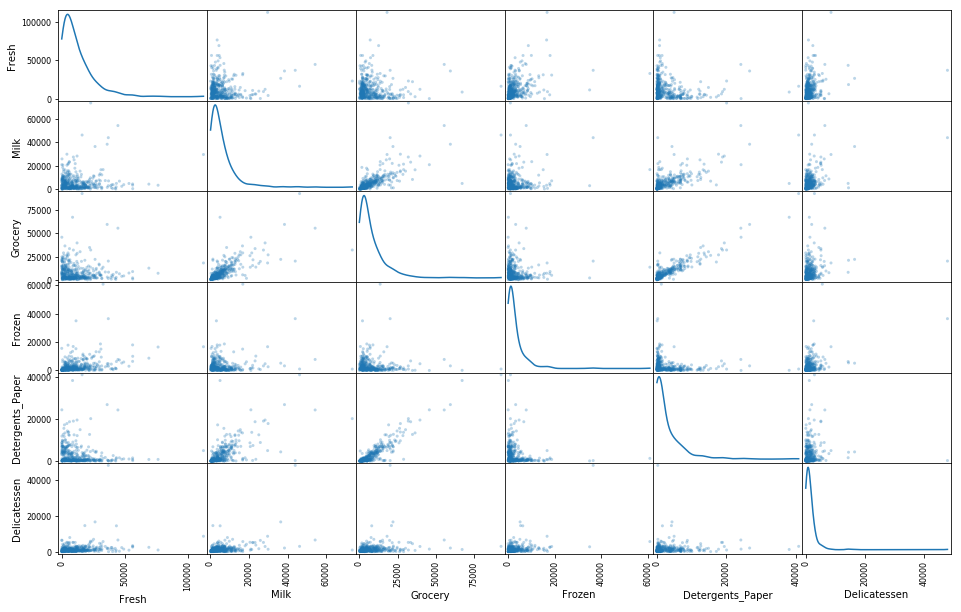

In [6]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (16,10), diagonal = 'kde');

In [7]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


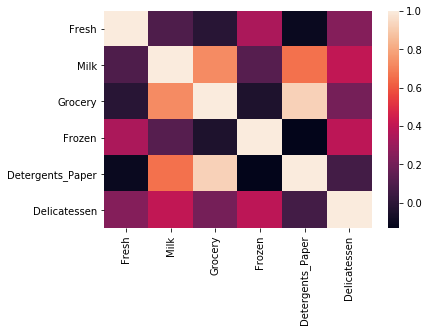

In [8]:
sns.heatmap(data.corr())

Exploring the data distribution with histograms:

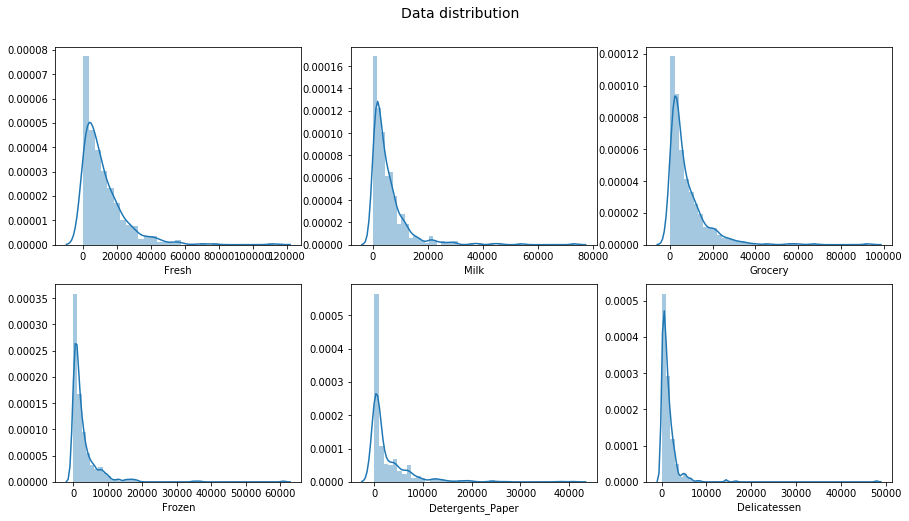

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(231)
sns.distplot(data.Fresh)
plt.subplot(232)
sns.distplot(data.Milk)
plt.subplot(233)
sns.distplot(data.Grocery)
plt.subplot(234)
sns.distplot(data.Frozen)
plt.subplot(235)
sns.distplot(data.Detergents_Paper)
plt.subplot(236)
sns.distplot(data.Delicatessen)
plt.suptitle('Data distribution')
plt.suptitle("Data distribution", fontsize = 14, y = 0.95)
plt.show()

As we can see above, **there are outliers** within each feature. In order to generate a better visualization for the distribution on the lower values for each feature, we are going to remove the big values, as they interfere on the X axis:

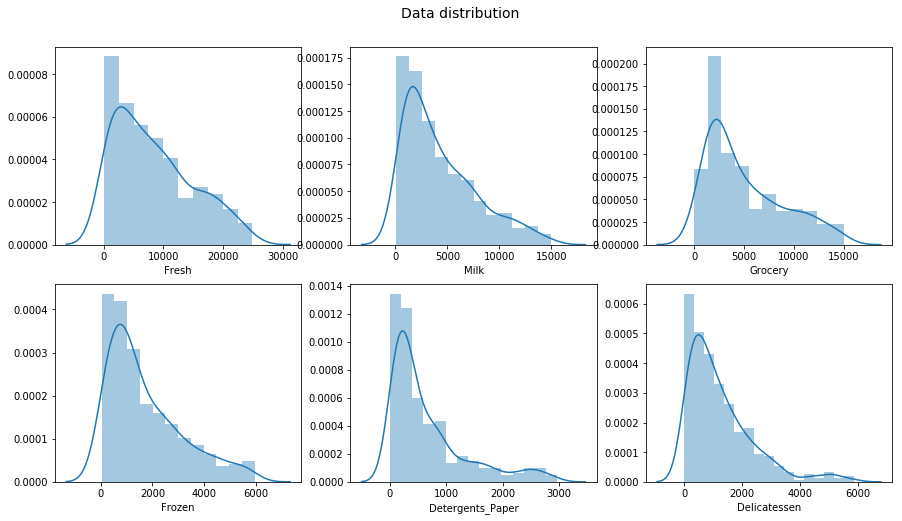

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(231)
sns.distplot(data.Fresh[data["Fresh"]<=25000])
plt.subplot(232)
sns.distplot(data.Milk[data["Milk"]<=15000])
plt.subplot(233)
sns.distplot(data.Grocery[data["Grocery"]<=15000])
plt.subplot(234)
sns.distplot(data.Frozen[data["Frozen"]<=6000])
plt.subplot(235)
sns.distplot(data.Detergents_Paper[data["Detergents_Paper"]<=3000])
plt.subplot(236)
sns.distplot(data.Delicatessen[data["Delicatessen"]<=6000])
plt.suptitle("Data distribution", fontsize = 14, y = 0.95)
plt.show()

There is no evidence of a high degree of normality within the data distributions above. The KDE function inside the graphs try to fit the data within a normal distribution, but their predictions step out of the range (below zero values).

Actually, the distributions are highly ***right-skewed***, as we can see with the histograms and scatter matrices above.

### Question 3
* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
* Are there any pairs of features which exhibit some degree of correlation? 
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
* How is the data for those features distributed?

**Hint:** Is the data normally distributed? Where do most of the data points lie? You can use [corr()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to get the feature correlations and then visualize them using a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html)(the data that would be fed into the heatmap would be the correlation values, for eg: `data.corr()`) to gain further insight.

**Answer:**

* Using the scatter matrix as a reference, discuss the distribution of the dataset, specifically talk about the normality, outliers, large number of data points near 0 among others. If you need to sepearate out some of the plots individually to further accentuate your point, you may do so as well.
    > **Normality:** there is no evidence of a high degree of normality within the data distributions. This is explained above, with the visualizations.
    
    >**Outliers:** the data set has outliers within every feature.
    
    >**Number of data near 0:** the feature values have a bigger density near zero values. This is shown by the histogram visualizations above.

* Are there any pairs of features which exhibit some degree of correlation? 
    > As we can see using the heatmap above, the following pair of features exhibit some degree of correlation: Grocery/Milk; Detergents_Paper/Milk; Detergents_Paper/Grocery. The strongest correlations are between Detergents_Paper/Grocery, while the correlations with the Milk feature are relatively mild.
* Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? 
    > This confirms what we found in previous analysis. We found out that the Milk feature is necessary because the other features cannot predict it. In other words, this shows us a mild correlation between the Milk feature and the other features.
* How is the data for those features distributed?
    > The data for these pair of features have a distribution with a better degree of linearity.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

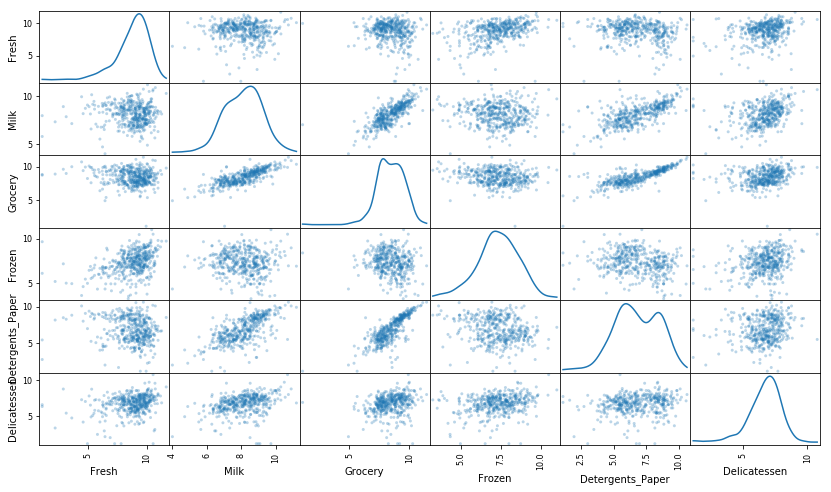

In [11]:
# TODO: Scale the data using the natural logarithm
log_data = data.apply(lambda x: np.log(x))

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.apply(lambda x: np.log(x))

# Produce a scatter matrix for each pair of newly-transformed features
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [12]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.489662,10.555005,10.995377,8.087640,10.192456,7.609367
1,8.732627,8.958669,9.288874,7.075809,8.052933,7.585789
2,7.299121,9.614605,9.386308,6.495266,8.266421,8.162801


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [13]:
################################Modified Code######################
multivariate_outliers = pd.DataFrame()
temp_outliers = pd.DataFrame()

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(a=log_data[feature], q=25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 =  np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    temp_outliers = temp_outliers.append(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])

################################Modified Code######################
multivariate_outliers = temp_outliers[temp_outliers.duplicated()==True]
multivariate_outliers = multivariate_outliers.drop_duplicates()
print("Data points considered outliers for MORE THAN ONE FEATURE: ")
display(multivariate_outliers)
# OPTIONAL: Select the indices for data points you wish to remove
#outliers  = []
outliers = list(multivariate_outliers.index)

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Data points considered outliers for MORE THAN ONE FEATURE: 


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612


### Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

* Are there any data points considered outliers for more than one feature based on the definition above? 
> Yes, there are outliers for more than one feature. They are were shown above.
* Should these data points be removed from the dataset? 
> Yes, they should be removed.
* If any data points were added to the `outliers` list to be removed, explain why.
> Having outliers within the dataset can change the outcome of our next steps in clustering analysis (the PCA algorithm and the KMeans and/or the Gaussian Mixture Modeling algorithms). Moreover, they are not a representative part of the customers. So, it is a good strategy to remove them, as they can interfere on finding the major customer segments within the data.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

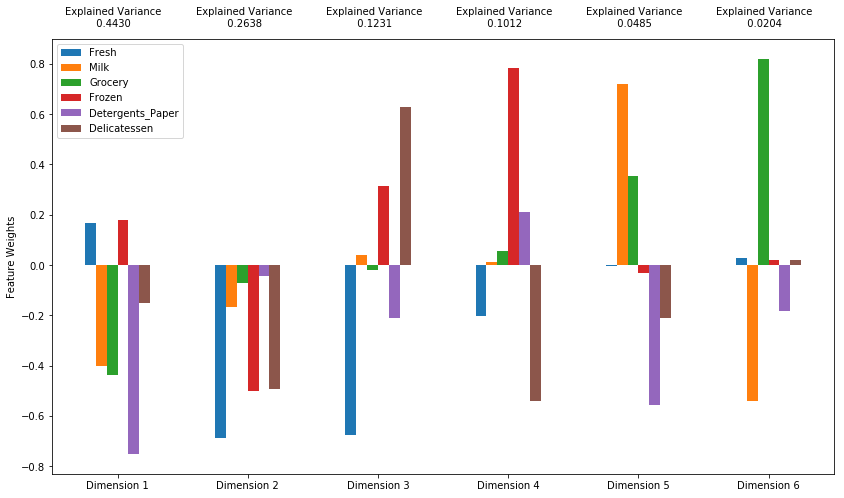

In [14]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA().fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [15]:
pca.explained_variance_ratio_[:2].sum()

0.7068172308068138

In [16]:
pca.explained_variance_ratio_[:4].sum()

0.9310901099509613

### Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

**Answer:**

* How much variance in the data is explained* **in total** *by the first and second principal component? 
> 70.68 %
* How much variance in the data is explained by the first four principal components? 
> 93.11 %
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

    First, it is good to remember that the **weight absolute values** for each feature within the dimensions are important information. The negative sign only shows us that the positive direction of the PC dimension is opposite to te positive direction of the feature axis.

    **Dimension 1**
    > As we can see above, the first PC has the following three major features: **Detergents_Paper, Grocery** and **Milk**. This confirms what we found out on previous analysis (Question 3), because the pairs of features with high correlation are Grocery/Milk, Detergents_Paper/Milk, Detergents_Paper/Grocery. We can think about these relationships as the following:
    
    > - The Milk feature can be predicted in a high degree of linearity using the Grocery feature, or vice-versa.
    
    > - The Grocery feature can be predicted in a high degree of linearity using the Detergents_Paper feature, or vice-versa.
    
    > - So, the Milk feature can be predicted in a high degree of linearity using the Detergents_Paper feature.
    
    > All of the previous sentences are translated to us by the first PC of the result by the bars with negative values. These values mean that a increase in the first PC will generate a decrease in these 3 features (the original feature space).
    
    > Another point here is that this Dimension can be thought of as a **degree of freedom** for separating the customers which differ from these 3 features (spend in Detergents_Paper, Grocery and Milk) by a substantial amount of spendings. For example, this dimension could separate a big retail market from a cafe. Obs: it is good to remember that this dimension is also influenced by other features with a lower weight.
    
    **Dimension 2**
    > The major features within this dimension are **Fresh**, **Frozen** and **Delicatessen**. We didn't see the correlations between these features because their impact on the data distribution is much smaller, as the variance explained by this dimension is 0.2638.
    
    > This dimension can separate customers like restaurants from markets which don't need frozen and fresh products.
    
    **Dimension 3**
    
    > Here, the major features are **Fresh** and **Delicatessen**. So, this dimension can also help separating specific types of restaurants and markets.
    
    **Dimension 4**
    
    > Here, the major features are **Frozen** and **Delicatessen**. So, this dimension can also help separating specific types of restaurants and markets.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-4.3474,-2.7451,-1.0220,0.6346,0.5311,0.2344
1,-1.8222,-0.5433,0.2567,-0.3523,0.0136,0.0142
2,-2.7186,0.3198,1.3868,-0.7698,0.3031,-0.3414


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [18]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-4.3474,-2.7451
1,-1.8222,-0.5433
2,-2.7186,0.3198


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

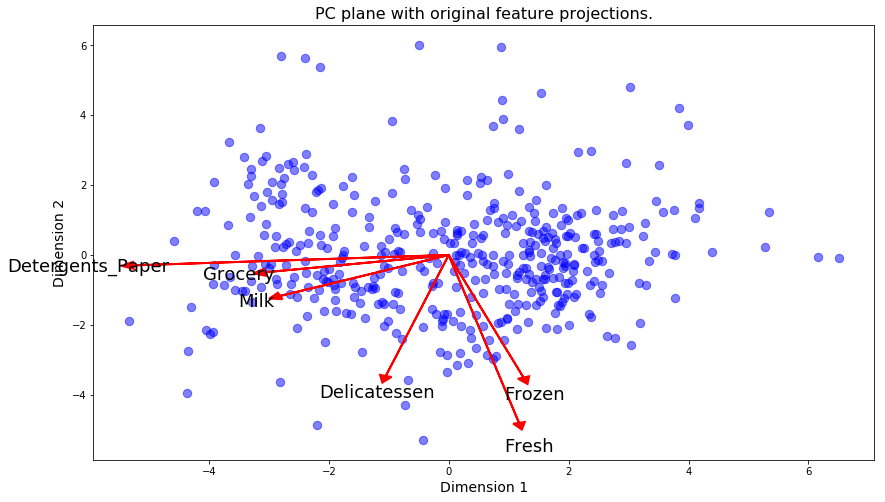

In [20]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

* What are the advantages to using a K-Means clustering algorithm? 
> One of the advantages is that it is a simple and easy to understand algorithm. The idea of the **cluster center** and its distances to the data points is easy to explain. This is added to the **hard cluster assignment** idea so that it becomes very intuitive. Also, the K-Means algorithm has a **fast processing time** when compared to other algorithms at a **high number of data points**, and this works well in practice.
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
> One of the advantages of the Gaussian Mixture Model is that it is good for **density estimation applications** within data sets. This is possible because of the **probability distribution** approach of this algorithm, also labeled as a **soft assingment** clustering algorithm. This allows **mixed memberships** within the clusters and the data points, so that there is a degree to assign a data point to a cluster. There are applications which requires this approach.
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?


>We know the following about the data:
>- The data seem to be normal distributions within each feature (after the log transformation). This can be an indicative of using Gaussian Mixture Model
>- The data had Tukey's Method outliers on more than one feature. These outliers were removed.
>- There are pairs of features which have high correlation

>Gaussian Mixture Model -> Soft clustering.
>One approach for the clustering method is to use a soft assignment cluster algorithm, as we are studying customer segments and this can be seen as a mixed membership problem, and not a hard assigment clustering problem.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [21]:
from sklearn.mixture import GaussianMixture

for n_clusters in range(2,11):

    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.means_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    print("Silhouette Score for {} clusters: {:.3f}".format(n_clusters, score))

Silhouette Score for 2 clusters: 0.422
Silhouette Score for 3 clusters: 0.376
Silhouette Score for 4 clusters: 0.311
Silhouette Score for 5 clusters: 0.310
Silhouette Score for 6 clusters: 0.311
Silhouette Score for 7 clusters: 0.333
Silhouette Score for 8 clusters: 0.256
Silhouette Score for 9 clusters: 0.324
Silhouette Score for 10 clusters: 0.263


We can use almost the same code to check the KMeans results:

In [22]:
from sklearn.cluster import KMeans

for n_clusters in range(2,11):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    print("Silhouette Score for {} clusters: {:.3f}".format(n_clusters, score))

Silhouette Score for 2 clusters: 0.426
Silhouette Score for 3 clusters: 0.397
Silhouette Score for 4 clusters: 0.332
Silhouette Score for 5 clusters: 0.350
Silhouette Score for 6 clusters: 0.366
Silhouette Score for 7 clusters: 0.365
Silhouette Score for 8 clusters: 0.364
Silhouette Score for 9 clusters: 0.368
Silhouette Score for 10 clusters: 0.363


### Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

The best number of clusters is 2. This was the best result for both the Gaussian Mixture Model and KMeans algorithms.

Running the code for only 2 clusters:

In [23]:
n_clusters=2
# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(n_components=n_clusters).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data,preds)
print("Silhouette Score for {} clusters: {:0.3f}".format(n_clusters, score))

Silhouette Score for 2 clusters: 0.422


### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

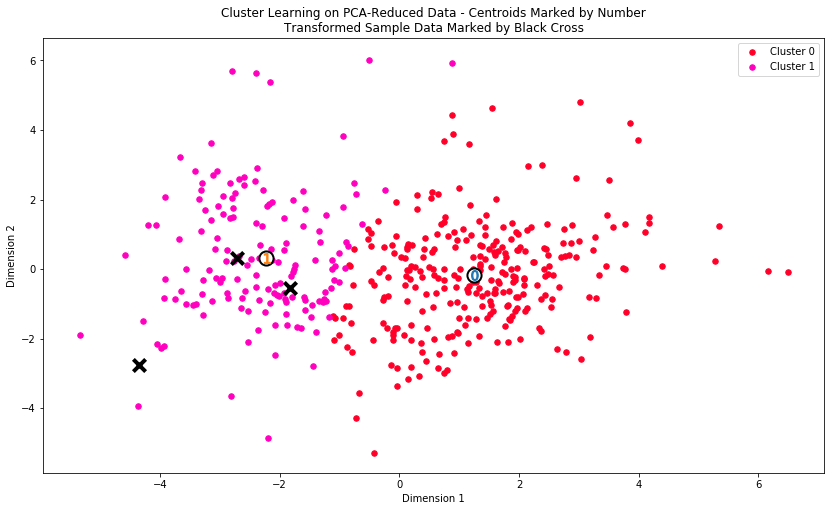

In [24]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

As we can see above, the **Dimension 1** is the **major classifier for the cluster assignment**. As we change the value of the Dimension 1, we can change between the clusters. This is opposed to the Dimension 2, because we change its value and **still end up within the same cluster**.

So, we can say that the **Dimension 1 has a higher weight for cluster assignment**. This is the same of saying that the Detergents_Paper, Grocery and Milk features have a higher weight, as they are the major features within the Dimension 1. However, we **cannot forget about the other features (Frozen, Fresh, Delicatessen)** as they have some degree of projection on the Dimension 1, as we can see with the Biplot. So, depending of the values for these last 2 features, they can represent some degree of assingment between the clusters.

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [25]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8939.0,2108.0,2758.0,2073.0,352.0,730.0
Segment 1,3567.0,7860.0,12249.0,873.0,4713.0,966.0


Next we are plotting the values given above, added to the **median** and **mean** values for each feature. We should also consider the median values because the mean values are influenced by **outliers** and the original distribution **does not have a high degree of normality** within this dataset, as we studied before. The mean values are good indicators of **central tendency** when we have a normal distribution.

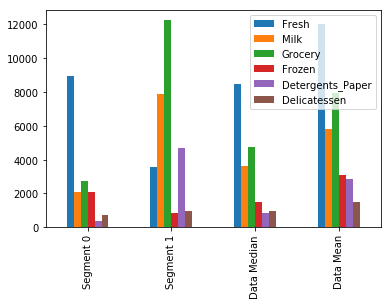

In [26]:
compare = true_centers.copy()
compare.loc[true_centers.shape[0]] = data.median()
compare.loc[true_centers.shape[0]+1] = data.mean()

compare.plot(kind='bar')
labels = true_centers.index.values.tolist()
labels.append("Data Median")
labels.append("Data Mean")
plt.xticks(range(compare.shape[0]),labels);

The total spend can tell us more about the establishment and its size. In order to check that we should compute the sum for each row and check its median and mean values:

In [27]:
print('Total spend for Segment 0: ',true_centers.iloc[0].sum())
print('Total spend for Segment 1: ',true_centers.iloc[1].sum())

Total spend for Segment 0:  16960.0
Total spend for Segment 1:  30228.0


In [28]:
total_spend = data.copy().sum(axis=1)
print("Total median spend: {:.2f}".format(total_spend.median()))
print("Total mean spend: {:.2f}".format(total_spend.mean()))

Total median spend: 27492.00
Total mean spend: 33226.14


### Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

**Segment 1:**

This segment spends more on Milk, Grocery and Detergents_Paper products than the other types of products. Moreover these spends are bigger than the median and mean values of the spends. This can be an indicative that it is a establishment within the market segment.

The total spend suggests that the size of the establishment is similar to the central tendency of the dataset, because the total spend value is near the median and mean total spend values.

**Segment 0:**

This segment spends more on Fresh, Grocery, Milk and Frozen products. However, when we compare with the median values within the dataset we see that it spends more on Fresh and Frozen products than the central tendency of the population. So, this can be an indicative that it is a restaurant.

The higher values for Fresh and Frozen products confirms what we saw using the Biplot. The Dimension 1 also has a component of the Fresh and Frozen features, but with a diminished weight. For higher values of these 2 features and lower values of the major features within this Dimension (Milk, Grocery and Detergents_Paper) the customer segment changes as the cluster visualization shows us.

Also, the total spend suggests that its size is much smaller than the central tendency of the dataset.

Visualizing the samples again:

In [29]:
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,35942,38369,59598,3254,26701,2017
1,6202,7775,10817,1183,3143,1970
2,1479,14982,11924,662,3891,3508


### Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [30]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


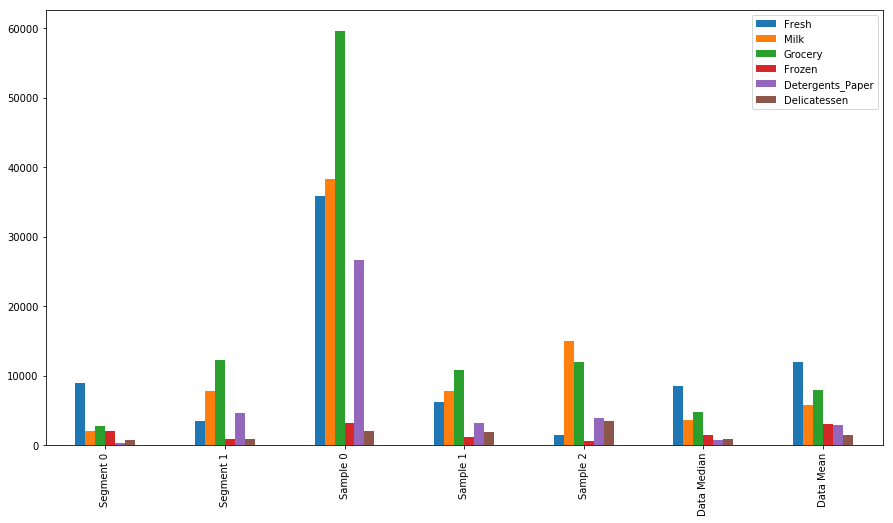

In [31]:
compare = true_centers.copy()
compare.loc[true_centers.shape[0]+1] = samples.iloc[0]
compare.loc[true_centers.shape[0]+2] = samples.iloc[1]
compare.loc[true_centers.shape[0]+3] = samples.iloc[2]
compare.loc[true_centers.shape[0]+4] = data.median()
compare.loc[true_centers.shape[0]+5] = data.mean()

compare.plot(kind='bar', figsize=(15,8))
labels = true_centers.index.values.tolist()
labels.append("Sample 0")
labels.append("Sample 1")
labels.append("Sample 2")
labels.append("Data Median")
labels.append("Data Mean")
plt.xticks(range(compare.shape[0]),labels);

**Answer:**

* For each sample point, which customer segment from **Question 8** best represents it? 
    >Sample 0 - in this case we can see that the spend values are higher than the central tendency for **all of the types of products**. However the spends are very high for **Fresh, Milk, Grocery and Detergents_Paper**. As we studied before using the Biplot and the PCs analysis, the Milk, Grocery and Detergents_Paper features have **higher (negative) weights within the Dimension 1**. Also, we studied that the Dimension 1 has a high degree of separability between the 2 clusters. So, the very big values of these 3 last features contribute to make this sample part of the cluster 1. Using our analysis we can say that this establishment is a big market.

    >Sample 1 - this is the same situation for the Milk, Grocery and Detergents_Paper features of the sample 0. However, this case does not have values as big as the sample 0 case, but the Dimension 1 still manages to choose the cluster. So, we can say that this establishment is also a market, but it is **not as big** as the first case.

    >Sample 2 - same case as the other samples. The only difference is the very low value for Fresh products. So, using our analysis we can say that this establishment is also a market, but it has some **peculiarity** of its business.

* Are the predictions for each sample point consistent with this?*

    >All of the samples are predicted to be within the Cluster 1. So, yes, the predictions are consistent with this.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

The first thing to consider about A/B tests is that it is very important to use the domain knowledge and the data to check all the variables that impact the process. A/B tests need to be run on the same **scenario**, besides the features that we are testing. Some of these variables are the following:

> **Day of week**: are there differences within the dataset distribution regarding the day of the week? For example, the customers buy more products on thursday and friday for the weekend?

> **Holidays**: holidays can change the spend values, so depending on the problem it is not a good approach to run A/B tests on holidays.

**First Approach**

We cannot assume that the change will affect all customers equally. The following way of thinking shows us this relationship:
- What the delivery service affects in terms of products?
> A higher delivery rate is better for products which have lower expiration time, like Milk and Fresh products. On the other hand, lower delivery rate does not compromise Frozen and Detergents_Paper products for example.
- What are the customer segments which spend more on the low expiration type of products?
> These customers are more likely to be affected by the change on the delivery rate. So, the customers within the Cluster 0 are going to be the population for the test, as they are not affected as the degree of the Cluster 1 customers are.
- Sample customers
> Apply a sampling technique within customers from Segment 0 and run A/B tests.


Experimental group: customers from Segment 0 that were chosen from the sampling technique.

Control group: remaining customers from Segment 0.

**Second Approach**

Depending on the result of the first approach, we are not going to run any other tests. If the results were money savings, we will consider this second approach.

Here, it is interesting to check if we can save money with delivery costs for the other segment, Segment 1. So we will be applying the same sampling technique and run the tests considering the following groups:

Experimental group: customers from Segment 1 that were chosen from the sampling technique.

Control group: remaining customers from Segment 1.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

The wholesale distributor could use the analysis generated by this project and fill the original data with labels: the customer segment. After that a classifier could be trained with the data and be used to classify the new customers.

This approach can be used within a pipeline which the new customers update de original database, and constantly update the results of the analysis of the segments. This can be used to constantly check if the customers are changing.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

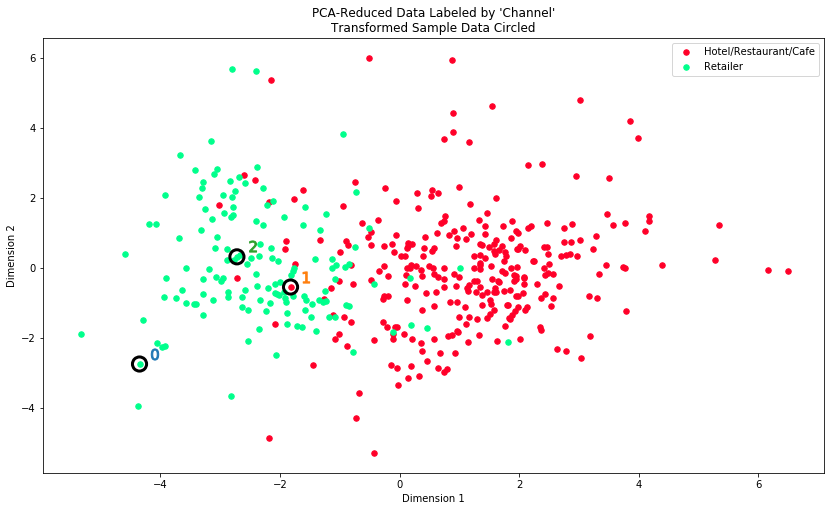

In [32]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

Let's check the similarity between the cluster analysis and the real labeled data using the Adjusted Random Index:

In [33]:
try:
    full_data = pd.read_csv("customers.csv")
except:
    print("Dataset could not be loaded. Is the file missing?")
channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
ari = adjusted_rand_score(channel.values.reshape(channel.shape[0]),preds)
print("Adjusted Random Index: {:.3f}".format(ari))

Adjusted Random Index: 0.647


This index has a value between -1 and 1, 1 being the perfect match and 0 being random prediction.

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

The number of clusters that returns the best silhouette score is the same number of clusters of the full data. Also, the distribution within the reduced feature space looks like the original data. The Adjusted Random Index is 0.639.

Regarding the pure classes, there are segments which can be classified as pure 'Retailers' or 'Hotels/Restaurants/Cafes'. However, there are regions that it is not clear which class the data points belong to. So, we could use the probabilities given by the Gaussian Mixture Model to show this mixed membership area.

Regarding the previous definitions of the segments, yes, they are consistent with the Question 8 study, except the Sample 1 which wasn't clustered correctly. However, when we first looked at the samples before Question 1, the definition used for the Sample 1 was a cafe establishment, which seems more appropriate for this case. The Sample 2 was considered as a bakery during this first look at the data, but it was not correct as we can see in Question 8.